## Calcular residuo de stokes

In [47]:
import numpy as np
from skfem import (
    MeshTri, Basis, FacetBasis, ElementTriP2, ElementTriP1, ElementVector,
    asm, bmat, condense, solve, BilinearForm, LinearForm
)
from skfem.models.general import divergence
from skfem.models.poisson import vector_laplace
from skfem.helpers import grad, dot, laplacian
from skfem.helpers import laplacian, precompute_operators
import matplotlib.pyplot as plt


## Stokes

In [2]:
def graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u):
    
    Nu = basis_u.N
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # Separar componentes de velocidad
    # Para ElementVector, los DOFs están organizados por componente
    n_nodes = Nu // 2
    u_x = u_sol[0::2]  # componente x
    u_y = u_sol[1::2]  # componente y

    # Magnitud de velocidad
    u_magnitude = np.sqrt(u_x**2 + u_y**2)

    # Crear bases escalares para visualizar cada componente
    basis_scalar = Basis(mesh, ElementTriP2(), intorder=4)

    # Componente u de la velocidad
    basis_scalar.plot(u_x, ax=axes[0, 0], shading='gouraud', colorbar=True)
    axes[0, 0].set_title(r'Velocidad $u_x$ (horizontal)')
    axes[0, 0].set_aspect('equal')

    # Componente v de la velocidad
    basis_scalar.plot(u_y, ax=axes[0, 1], shading='gouraud', colorbar=True)
    axes[0, 1].set_title(r'Velocidad $u_y$ (vertical)')
    axes[0, 1].set_aspect('equal')

    # Magnitud de velocidad
    basis_scalar.plot(u_magnitude, ax=axes[1, 0], shading='gouraud', colorbar=True)
    axes[1, 0].set_title(r'Magnitud de velocidad $|\mathbf{u}|$')
    axes[1, 0].set_aspect('equal')

    # Presión
    basis_p.plot(p_sol, ax=axes[1, 1], shading='gouraud', colorbar=True)
    axes[1, 1].set_title(r'Presión $p$')
    axes[1, 1].set_aspect('equal')

    plt.tight_layout()
    plt.show()

def graficar_laplaciano(mesh, lap_u_x, lap_u_y, lap_p):

    plt.figure(figsize=(8,6))
    scatter_ux = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_u_x, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_ux, label='$\\Delta u_x$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta u_x$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

    # Laplaciano de u_y
    plt.figure(figsize=(8,6))
    scatter_uy = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_u_y, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_uy, label='$\\Delta u_y$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta u_y$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

    # Laplaciano de la presión
    plt.figure(figsize=(8,6))
    scatter_p = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_p, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_p, label='$\\Delta p$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta p$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

In [3]:
# Definir dominio y mallado
nx, ny = 64, 64
mesh = MeshTri.init_tensor(
    np.linspace(0.0, 1.0, nx + 1), 
    np.linspace(0.0, 1.0, ny + 1)
)
# mesh = MeshTri.init_symmetric().refined(3)

In [4]:
def u_exact_x(x, y):
    nu   = 0.1
    Re   = 1/nu
    lamb = Re/2-np.sqrt(Re*Re/4+4*np.pi*np.pi)
    return 1- np.exp(lamb*x)*np.cos(2*np.pi*y)

def u_exact_y(x, y):
    nu   = 0.1
    Re   = 1/nu
    lamb = Re/2-np.sqrt(Re*Re/4+4*np.pi*np.pi)
    return  lamb/(2*np.pi)*np.exp(lamb*x)*np.sin(2*np.pi*y)

def p_exact_xy(x, y):
    nu   = 0.1
    Re   = 1/nu
    lamb = Re/2-np.sqrt(Re*Re/4+4*np.pi*np.pi)
    return 0.5*np.exp(2*lamb*x) + 0*y

def f_exact_x(x, y):
    nu   = 0.1
    Re   = 1/nu
    lamb = Re/2-np.sqrt(Re*Re/4+4*np.pi*np.pi)
    return (nu * (lamb**2 - 4*np.pi**2) * np.exp(lamb*x) * np.cos(2*np.pi*y)
            + lamb * np.exp(2*lamb*x))

def f_exact_y(x, y):
    nu   = 0.1
    Re   = 1/nu
    lamb = Re/2-np.sqrt(Re*Re/4+4*np.pi*np.pi)
    return (-nu * lamb * (lamb**2 - 4*np.pi**2) / (2*np.pi)
            * np.exp(lamb*x) * np.sin(2*np.pi*y))

In [5]:
# Asignar ID a las fronteras

mesh = mesh.with_boundaries({
    'left':   lambda x: x[0] == 0.0,
    'right':  lambda x: x[0] == 1.0,
    'bottom': lambda x: x[1] == 0.0,
    'top':    lambda x: x[1] == 1.0,
})

In [6]:
# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(mesh, element['u'], intorder=4),
    'p': Basis(mesh, element['p'], intorder=4),
}

In [7]:
basis_u = basis['u']
basis_p = basis['p']
Nu      = basis_u.N
Np      = basis_p.N
nu      = 0.1  # Viscosidad cinemática
# Ensamblaje de matrices
A =  nu *asm(vector_laplace, basis['u'])
B = -asm(divergence, basis['u'], basis['p'])

K = bmat([[A, B.T],
        [B, None]], format='csr')

x_boundary = np.zeros(Nu + Np)

In [8]:
# Obtener DOFs de las fronteras de la base de velocidad
dofs_left     = basis_u.get_dofs('left').all()
dofs_right    = basis_u.get_dofs('right').all()
dofs_top      = basis_u.get_dofs('top').all()
dofs_bottom   = basis_u.get_dofs('bottom').all()

# Elementos con condiciones de Dirichlet para la velocidad
# Impares y, pares x
y_left   = basis_u.doflocs[1, dofs_left[1::2]] 
y_right  = basis_u.doflocs[1, dofs_right[1::2]]

x_left   = basis_u.doflocs[0, dofs_left[::2]]  
x_right  = basis_u.doflocs[0, dofs_right[::2]]

x_top    = basis_u.doflocs[0, dofs_top[::2]]
x_bottom = basis_u.doflocs[0, dofs_bottom[::2]]

y_top    = basis_u.doflocs[1, dofs_top[1::2]]
y_bottom = basis_u.doflocs[1, dofs_bottom[1::2]]


x_boundary[dofs_left[::2]]    =  u_exact_x(x_left, y_left)  # componente x
x_boundary[dofs_left[1::2]]   =  u_exact_y(x_left, y_left)  # componente y

x_boundary[dofs_right[::2]]   =  u_exact_x(x_right, y_right)  # componente x
x_boundary[dofs_right[1::2]]  =  u_exact_y(x_right, y_right)  # componente y

x_boundary[dofs_top[::2]]     =  u_exact_x(x_top, y_top)  # componente x
x_boundary[dofs_top[1::2]]    =  u_exact_y(x_top, y_top)  # componente y

x_boundary[dofs_bottom[::2]]  =  u_exact_x(x_bottom, y_bottom)  # componente x
x_boundary[dofs_bottom[1::2]] =  u_exact_y(x_bottom, y_bottom)  # componente y

dofs_u_boundary = np.concatenate([
    dofs_left,
    dofs_right,
    dofs_top,
    dofs_bottom
])

# Obtener DOFs de las fronteras de la base de velocidad
# dofs_left_p     = basis_p.get_dofs('left').all()
# dofs_right_p    = basis_p.get_dofs('right').all()
# dofs_top_p      = basis_p.get_dofs('top').all()
# dofs_bottom_p   = basis_p.get_dofs('bottom').all()

x_boundary[Nu + 0]  = 0.5

dofs_p_boundary = Nu + np.concatenate([
    np.array([0])
    # dofs_right_p,
    # dofs_top_p,
    # dofs_bottom_p
])

D_all = np.unique(np.concatenate([dofs_u_boundary, dofs_p_boundary]))


In [9]:
@LinearForm
def rhs_u(v, w):
    x, y = w.x
    fx = f_exact_x(x, y)
    fy = f_exact_y(x, y)
    return fx * v[0] + fy * v[1]

b_u = asm(rhs_u, basis_u) 
b_p = np.zeros(Np)  
F   = np.concatenate([b_u, b_p])

In [10]:
# Resolver sistema condensado
sol_full = solve(*condense(K, F, D=D_all, x=x_boundary))

# Extraer soluciones
u_sol = sol_full[:Nu]
p_sol = sol_full[Nu:]

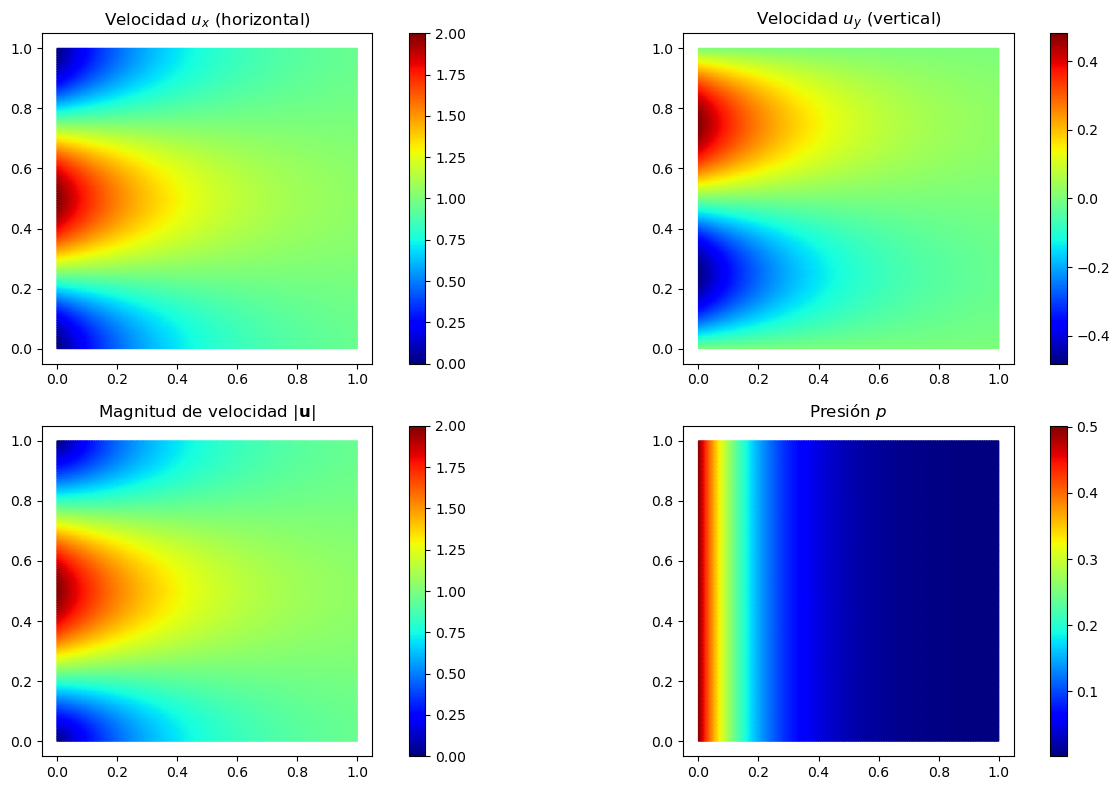

In [11]:
graficar_stokes(u_sol, p_sol, mesh, basis_p, basis_u)

### Calcular residuo de stokes (strong)

In [12]:
basis_x = basis_u.split_bases()[0]
basis_y = basis_u.split_bases()[1]
u_x = u_sol[0::2]
u_y = u_sol[1::2]

edofs_x, phix, grad_phix, laplacian_phix = precompute_operators(basis_x)
edofs_y, phiy, grad_phiy, laplacian_phiy = precompute_operators(basis_y)
edofs_p, phip, grad_phip, laplacian_phip = precompute_operators(basis_p, calculate_laplacian=False)

In [13]:
# Calcular operadores en coordenadas físicas
grad_u_fisico_x = np.einsum('de, diqe -> iqe', u_x[edofs_x], grad_phix)
grad_u_fisico_y = np.einsum('de, diqe -> iqe', u_y[edofs_y], grad_phiy)
grad_p_fisico   = np.einsum('de, diqe -> iqe', p_sol[edofs_p], grad_phip)
laplacian_u_x   = np.sum(u_x[edofs_x] * laplacian_phix, axis=0)
laplacian_u_y   = np.sum(u_y[edofs_y] * laplacian_phiy, axis=0)

du_dx = grad_u_fisico_x[0]
du_dy = grad_u_fisico_x[1]
dv_dx = grad_u_fisico_y[0]
dv_dy = grad_u_fisico_y[1]
dp_dx = grad_p_fisico[0]
dp_dy = grad_p_fisico[1]


In [14]:
# Coordenadas de los puntos de cuadratura reales
coords = basis_x.global_coordinates()
X_quad = coords[0]
Y_quad = coords[1]

val_f_x = f_exact_x(X_quad, Y_quad) # Salida: (32, 6)
val_f_y = f_exact_y(X_quad, Y_quad) # Salida: (32, 6)

In [15]:
# Residuo momentum en X: dp/dx - nu*Lap(u)
nu = 0.1
res_momentum_x = np.abs(-(nu * laplacian_u_x) + dp_dx - val_f_x.T)

# Residuo momentum en Y: dp/dy - nu*Lap(v)
res_momentum_y = np.abs(-(nu * laplacian_u_y) + dp_dy - val_f_y.T)

# Residuo Continuidad: du/dx + dv/dy
res_continuity = np.abs(du_dx + dv_dy)

print(f"Residuo momentum en X - min: {np.min(res_momentum_x):.4e}, max: {np.max(res_momentum_x):.4e}")
print(f"Residuo momentum en Y - min: {np.min(res_momentum_y):.4e}, max: {np.max(res_momentum_y):.4e}")
print(f"Residuo continuidad - min: {np.min(res_continuity):.4e}, max: {np.max(res_continuity):.4e}")

Residuo momentum en X - min: 3.1556e-07, max: 3.0353e-01
Residuo momentum en Y - min: 5.3200e-08, max: 1.6764e-01
Residuo continuidad - min: 2.2829e-09, max: 4.5374e-03


### Residuo débil

In [123]:
basis_x = basis_u.split_bases()[0]
basis_y = basis_u.split_bases()[1]
u_x = u_sol[0::2]
u_y = u_sol[1::2]

edofs_x, phix, grad_phix, laplacian_phix = precompute_operators(basis_x, calculate_laplacian=False)
edofs_y, phiy, grad_phiy, laplacian_phiy = precompute_operators(basis_y, calculate_laplacian=False)
edofs_p, phip, grad_phip, laplacian_phip = precompute_operators(basis_p, calculate_laplacian=False)
#(q,e) , (d,q), (d,i,q,e)

dx = basis_x.dx #(d,e)

In [124]:
dofs_boundary_u = basis_u.boundary().get_dofs().all()
dofs_boundary_p = basis_p.boundary().get_dofs().all()
dofsx = dofs_boundary_u[::2]
dofsy = dofs_boundary_u[1::2]
dofsp = dofs_boundary_p

In [125]:
all_boundary_facets = np.concatenate([
    mesh.boundaries['left'],
    mesh.boundaries['right'],
    mesh.boundaries['bottom'],
    mesh.boundaries['top'],
])
elem_of_facet = mesh.f2t

els_bdry = elem_of_facet[:, all_boundary_facets].ravel()
els_bdry = els_bdry[els_bdry >= 0]
els_bdry = np.unique(els_bdry)


In [126]:
u_quad = np.einsum('de, dq -> eq', u_x[edofs_x], phix) 
v_quad = np.einsum('de, dq -> eq', u_y[edofs_y], phiy)
p_quad = np.einsum('de, dq -> eq', p_sol[edofs_p],  phip)

In [127]:
# Coordenadas de los puntos de cuadratura reales
coords = basis_x.global_coordinates()
X_quad = coords[0]
Y_quad = coords[1]

val_f_x = f_exact_x(X_quad, Y_quad) # (e, d)
val_f_y = f_exact_y(X_quad, Y_quad) # (e, d)

In [128]:
# Calcular operadores en coordenadas físicas
grad_u_phys_x = np.einsum('de, diqe -> ieq', u_x[edofs_x], grad_phix)
grad_u_phys_y = np.einsum('de, diqe -> ieq', u_y[edofs_y], grad_phiy)

du_dx = grad_u_phys_x[0]
du_dy = grad_u_phys_x[1]
dv_dx = grad_u_phys_y[0]
dv_dy = grad_u_phys_y[1]
dphi_dx = grad_phix[:, 0, :, :]
dphi_dy = grad_phiy[:, 1, :, :]

In [129]:
# Compute variational terms
conv_x = u_quad * du_dx + v_quad * du_dy
conv_y = u_quad * dv_dx + v_quad * dv_dy
diff_x = np.einsum('ieq, diqe -> edq', grad_u_phys_x, grad_phix)
diff_y = np.einsum('ieq, diqe -> edq', grad_u_phys_y, grad_phiy)
div_u  = du_dx + dv_dy

# Compute residuals
R_conv_x = np.einsum('eq, dq, eq -> ed', conv_x, phix, dx)
R_conv_y = np.einsum('eq, dq, eq -> ed', conv_y, phiy, dx)
R_diff_x = np.einsum('edq, eq -> ed', diff_x, dx)
R_diff_y = np.einsum('edq, eq -> ed', diff_y, dx)
R_pres_x = np.einsum('eq, dqe, eq -> ed', p_quad, dphi_dx, dx)
R_pres_y = np.einsum('eq, dqe, eq -> ed', p_quad, dphi_dy, dx)
R_cont   = np.einsum('eq, dq, eq -> ed', div_u, phip, dx)

R_f_x = np.einsum('eq, dq, eq -> ed', val_f_x, phix, dx)
R_f_y = np.einsum('eq, dq, eq -> ed', val_f_y, phiy, dx)

In [131]:
momentum_x = np.abs(np.sum(nu*R_diff_x - R_pres_x - R_f_x, axis=1))
momentum_y = np.abs(np.sum(nu*R_diff_y - R_pres_y - R_f_y, axis=1))
continuity = np.abs(np.sum(R_cont, axis=1))

print(f"Residuo momentum en X - min: {np.min(momentum_x):.4e}, max: {np.max(momentum_x):.4e}")
print(f"Residuo momentum en Y - min: {np.min(momentum_y):.4e}, max: {np.max(momentum_y):.4e}")
print(f"Residuo continuidad - min: {np.min(continuity):.4e}, max: {np.max(continuity):.4e}")

Residuo momentum en X - min: 6.8900e-09, max: 7.2224e-04
Residuo momentum en Y - min: 2.8527e-07, max: 1.7543e-04
Residuo continuidad - min: 6.9564e-14, max: 1.2156e-07


## Navier Stokes

In [31]:
def graficar_navier_stokes(u_sol, p_sol, mesh, basis_p, basis_u):
    
    Nu = basis_u.N
    
    # Visualización
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # Separar componentes de velocidad
    # Para ElementVector, los DOFs están organizados por componente
    n_nodes = Nu // 2
    u_x = u_sol[0::2]  # componente x
    u_y = u_sol[1::2]  # componente y

    # Magnitud de velocidad
    u_magnitude = np.sqrt(u_x**2 + u_y**2)

    # Crear bases escalares para visualizar cada componente
    basis_scalar = Basis(mesh, ElementTriP2(), intorder=4)

    # Componente u de la velocidad
    basis_scalar.plot(u_x, ax=axes[0, 0], shading='gouraud', colorbar=True)
    axes[0, 0].set_title(r'Velocidad $u_x$ (horizontal)')
    axes[0, 0].set_aspect('equal')


    # Componente v de la velocidad
    basis_scalar.plot(u_y, ax=axes[0, 1], shading='gouraud', colorbar=True)
    axes[0, 1].set_title(r'Velocidad $u_y$ (vertical)')
    axes[0, 1].set_aspect('equal')

    # Magnitud de velocidad
    basis_scalar.plot(u_magnitude, ax=axes[1, 0], shading='gouraud', colorbar=True)
    axes[1, 0].set_title(r'Magnitud de velocidad $|\mathbf{u}|$')
    axes[1, 0].set_aspect('equal')

    # Presión
    basis_p.plot(p_sol, ax=axes[1, 1], shading='gouraud', colorbar=True)
    axes[1, 1].set_title(r'Presión $p$')
    axes[1, 1].set_aspect('equal')

    plt.tight_layout()
    plt.show()

def graficar_laplaciano(mesh, lap_u_x, lap_u_y, lap_p):

    plt.figure(figsize=(8,6))
    scatter_ux = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_u_x, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_ux, label='$\\Delta u_x$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta u_x$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

    # Laplaciano de u_y
    plt.figure(figsize=(8,6))
    scatter_uy = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_u_y, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_uy, label='$\\Delta u_y$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta u_y$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

    # Laplaciano de la presión
    plt.figure(figsize=(8,6))
    scatter_p = plt.tripcolor(mesh.p[0], mesh.p[1], mesh.t.T, 
                            lap_p, 
                            shading='flat', 
                            cmap='RdBu_r')
    plt.colorbar(scatter_p, label='$\\Delta p$', shrink=0.5)
    plt.title('Laplaciano numérico $\\Delta p$ (por elemento)')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal')
    plt.show()

In [32]:
# Definir dominio y mallado
nx, ny = 32, 32
mesh = MeshTri.init_tensor(
    np.linspace(0.0, 1.0, nx + 1), 
    np.linspace(0.0, 1.0, ny + 1)
)

In [33]:
# Asignar ID a las fronteras
mesh = mesh.with_boundaries({
    'left':   lambda x: x[0] == 0.0,
    'right':  lambda x: x[0] == 1.0,
    'bottom': lambda x: x[1] == 0.0,
    'top':    lambda x: x[1] == 1.0,
})

In [34]:
# Definir elementos y bases (P2 para velocidad, P1 para presión)
element = {
    'u': ElementVector(ElementTriP2()),
    'p': ElementTriP1(),
}
basis = {
    'u': Basis(mesh, element['u'], intorder=4),
    'p': Basis(mesh, element['p'], intorder=4),
}
basis_u, basis_p = basis['u'], basis['p']
Nu, Np = basis_u.N, basis_p.N
N = Nu + Np

In [35]:
# Ensamblaje de matrices
A =  asm(vector_laplace, basis_u)               
B = -asm(divergence, basis_u, basis_p)         

# Término convectivo linealizado
@BilinearForm
def convection(u, v, w):
    # w['w'] es la velocidad conocida (campo vectorial)
    advection_field = w['w']
    
    # grad(u) es el tensor gradiente de la velocidad trial
    grad_u = grad(u)
    
    # La operación es: w_j * (d u_i / d x_j) * v_i
    # j...  -> índice de w y de la derivada (contracción)
    # ij... -> índices del gradiente (componente i, derivada j)
    # i...  -> índice de v (componente i)
    return np.einsum('j...,ij...,i...->...', advection_field, grad_u, v)

In [36]:
# Perfiles exacto

def u_exact_x(x, y):
    return x - y*0

def u_exact_y(x, y):
    return x*0 - y

def p_exact_xy(x, y):
    return x-2*y

def f_exact_x(x, y):
    return x + 1

def f_exact_y(x, y):
    return  y - 2

In [37]:
x_boundary = np.zeros(Nu + Np)

# Fronteras de la velocidad

# Obtener DOFs de las fronteras de la base de velocidad
dofs_left     = basis_u.get_dofs('left').all()
dofs_right    = basis_u.get_dofs('right').all()
dofs_top      = basis_u.get_dofs('top').all()
dofs_bottom   = basis_u.get_dofs('bottom').all()

# Elementos con condiciones de Dirichlet para la velocidad
# Impares y, pares x
y_left   = basis_u.doflocs[1, dofs_left[1::2]] 
y_right  = basis_u.doflocs[1, dofs_right[1::2]]

x_left   = basis_u.doflocs[0, dofs_left[::2]]  
x_right  = basis_u.doflocs[0, dofs_right[::2]]

x_top    = basis_u.doflocs[0, dofs_top[::2]]
x_bottom = basis_u.doflocs[0, dofs_bottom[::2]]

y_top    = basis_u.doflocs[1, dofs_top[1::2]]
y_bottom = basis_u.doflocs[1, dofs_bottom[1::2]]


x_boundary[dofs_left[::2]]    =  u_exact_x(x_left, y_left)  # componente x
x_boundary[dofs_left[1::2]]   =  u_exact_y(x_left, y_left)  # componente y

x_boundary[dofs_right[::2]]   =  u_exact_x(x_right, y_right)  # componente x
x_boundary[dofs_right[1::2]]  =  u_exact_y(x_right, y_right)  # componente y

x_boundary[dofs_top[::2]]     =  u_exact_x(x_top, y_top)  # componente x
x_boundary[dofs_top[1::2]]    =  u_exact_y(x_top, y_top)  # componente y

x_boundary[dofs_bottom[::2]]  =  u_exact_x(x_bottom, y_bottom)  # componente x
x_boundary[dofs_bottom[1::2]] =  u_exact_y(x_bottom, y_bottom)  # componente y

dofs_u_boundary = np.concatenate([
    dofs_left,
    dofs_right,
    dofs_top,
    dofs_bottom
])

x_boundary[Nu + 0]  = 0
dofs_p_boundary = np.array([Nu+0])# + np.concatenate([np.array([0])])

D_all = np.unique(np.concatenate([dofs_u_boundary, dofs_p_boundary]))

In [38]:
@LinearForm
def rhs_u(v, w):
    x, y = w.x
    fx = f_exact_x(x, y)
    fy = f_exact_y(x, y)
    return fx * v[0] + fy * v[1]

b_u = asm(rhs_u, basis_u) 
b_p = np.zeros(Np)  
F   = np.concatenate([b_u, b_p])

In [39]:
# Método de Picard
nu    = 1.0          # viscosidad
rho   = 1.0
maxit = 500
tol   = 1e-12
theta = 1.0          # sub-relajación (<=1). Usa 0.5–0.8 si no converge.

# Inicialización: toma la solución de Stokes como punto de partida (w=0 ⇒ C=0)
K_stokes = bmat([[nu * A, B.T],
                 [B,      None]], format='csr')
sol0 = solve(*condense(K_stokes, F, D=D_all, x=x_boundary))
u = sol0[:Nu].copy()
p = sol0[Nu:].copy()

for it in range(maxit):
    # Campo de advección congelado w := u^(it) en puntos de cuadratura
    W = basis_u.interpolate(u)   # DiscreteField utilizado como w['w'] por el form

    # Ensambla bloque convectivo C(w)
    C = asm(convection, basis_u, w=W)

    # Matriz bloque del paso linealizado
    K = bmat([[nu * A + rho * C, B.T],
              [B,          None]], format='csr')

    # Resolver con condensación de las CC (incluye x_bound)
    sol = solve(*condense(K, F, D=D_all, x=x_boundary))
    u_new = sol[:Nu]
    p_new = sol[Nu:]

    # Criterio de convergencia (corrección relativa en u)
    du = u_new - u
    rel_u = np.linalg.norm(du) / (np.linalg.norm(u_new) + 1e-16)

    dp = p_new - p
    rel_p = np.linalg.norm(dp) / (np.linalg.norm(p_new) + 1e-16)

    # # Sub-relajación si se desea
    u = (1.0 - theta) * u + theta * u_new
    p = (1.0 - theta) * p + theta * p_new

    if rel_u < tol and rel_p < tol:
        print(f"Convergió en {it+1} iteraciones, residuo {max(rel_u, rel_p):.2e}")
        break

# Solución final
u_sol, p_sol = u, p

Convergió en 14 iteraciones, residuo 6.13e-13


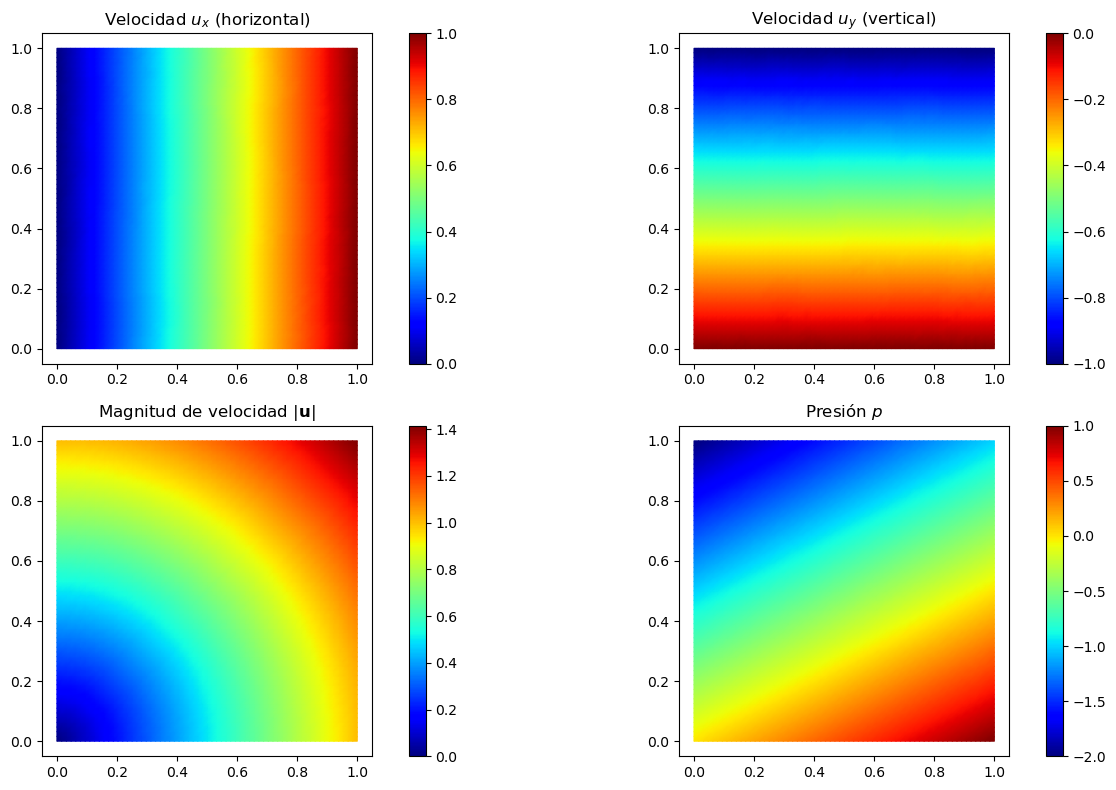

In [40]:
graficar_navier_stokes(u_sol, p_sol, mesh, basis_p, basis_u)

### Calcular residuo de Navier-Stokes (strong)

In [41]:
basis_x = basis_u.split_bases()[0]
basis_y = basis_u.split_bases()[1]
u_x = u_sol[0::2]
u_y = u_sol[1::2]

edofs_x, phix, grad_phix, laplacian_phix = precompute_operators(basis_x)
edofs_y, phiy, grad_phiy, laplacian_phiy = precompute_operators(basis_y)
edofs_p, phip, grad_phip, laplacian_phip = precompute_operators(basis_p)

In [42]:
# Velocidad y presión en puntos de cuadratura
u_val = np.einsum('dq, de -> qe', phix, u_x[edofs_x]) 
v_val = np.einsum('dq, de -> qe', phiy, u_y[edofs_y])
p_val = np.einsum('dq, de -> qe', phip, p_sol[edofs_p])

# Calcular operadores en coordenadas físicas
grad_u_fisico_x = np.einsum('de, diqe -> iqe', u_x[edofs_x], grad_phix)
grad_u_fisico_y = np.einsum('de, diqe -> iqe', u_y[edofs_y], grad_phiy)
grad_p_fisico   = np.einsum('de, diqe -> iqe', p_sol[edofs_p], grad_phip)
laplacian_u_x   = np.sum(u_x[edofs_x] * laplacian_phix, axis=0)
laplacian_u_y   = np.sum(u_y[edofs_y] * laplacian_phiy, axis=0)

du_dx = grad_u_fisico_x[0]
du_dy = grad_u_fisico_x[1]
dv_dx = grad_u_fisico_y[0]
dv_dy = grad_u_fisico_y[1]
dp_dx = grad_p_fisico[0]
dp_dy = grad_p_fisico[1]


In [43]:
# Coordenadas de los puntos de cuadratura reales
coords = basis_x.global_coordinates()
X_quad = coords[0]
Y_quad = coords[1]

val_f_x = f_exact_x(X_quad, Y_quad) # Salida: (32, 6)
val_f_y = f_exact_y(X_quad, Y_quad) # Salida: (32, 6)

In [46]:
# Residuo momentum en X: dp/dx - nu*Lap(u)
mu = 1.0
rho = 1.0
res_momentum_x = np.abs(rho*(u_val * du_dx + v_val * du_dy) + dp_dx - (mu * laplacian_u_x) - val_f_x.T)

# Residuo momentum en Y: dp/dy - nu*Lap(v)
res_momentum_y = np.abs(rho*(u_val * dv_dx + v_val * dv_dy) + dp_dy - (mu * laplacian_u_y) - val_f_y.T)

# Residuo Continuidad: du/dx + dv/dy
res_continuity = np.abs(du_dx + dv_dy)

print(f"Residuo momentum en X - min: {np.min(res_momentum_x):.4e}, max: {np.max(res_momentum_x):.4e}")
print(f"Residuo momentum en Y - min: {np.min(res_momentum_y):.4e}, max: {np.max(res_momentum_y):.4e}")
print(f"Residuo continuidad - min: {np.min(res_continuity):.4e}, max: {np.max(res_continuity):.4e}")

Residuo momentum en X - min: 4.4409e-16, max: 1.5782e-10
Residuo momentum en Y - min: 4.4409e-16, max: 1.5807e-10
Residuo continuidad - min: 0.0000e+00, max: 1.3127e-12


### Residuo débil

In [17]:
dofs_boundary_u = basis_u.boundary().get_dofs().all()
dofs_boundary_x = np.unique(dofs_boundary_u[0::2] // 2)  # mapear DOF vectorial -> escalar x
dofs_boundary_y = np.unique(dofs_boundary_u[1::2] // 2)  # mapear DOF vectorial -> escalar y
dofs_boundary_p = basis_p.boundary().get_dofs().all()

In [18]:
basis_x = basis_u.split_bases()[0]
basis_y = basis_u.split_bases()[1]
u_x = u_sol[0::2]
u_y = u_sol[1::2]

edofs_x, phix, grad_phix, laplacian_phix = precompute_operators(basis_x, calculate_laplacian=False)
edofs_y, phiy, grad_phiy, laplacian_phiy = precompute_operators(basis_y, calculate_laplacian=False)
edofs_p, phip, grad_phip, laplacian_phip = precompute_operators(basis_p, calculate_laplacian=False)
#(q,e) , (d,q), (d,i,q,e)

dx = basis_x.dx #(d,e)

In [19]:
mask_free_x = ~np.isin(edofs_x.T, dofs_boundary_x)  # (nelem, ndofs_loc)
mask_free_y = ~np.isin(edofs_y.T, dofs_boundary_y)
mask_free_p = ~np.isin(edofs_p.T, dofs_boundary_p)

In [20]:
u_quad = np.einsum('de, dq -> eq', u_x[edofs_x], phix) 
v_quad = np.einsum('de, dq -> eq', u_y[edofs_y], phiy)
p_quad = np.einsum('de, dq -> eq', p_sol[edofs_p],  phip)

In [21]:
# Coordenadas de los puntos de cuadratura reales
coords = basis_x.global_coordinates()
X_quad = coords[0]
Y_quad = coords[1]

val_f_x = f_exact_x(X_quad, Y_quad) # (e, d)
val_f_y = f_exact_y(X_quad, Y_quad) # (e, d)

In [22]:
# Calcular operadores en coordenadas físicas
grad_u_phys_x = np.einsum('de, diqe -> ieq', u_x[edofs_x], grad_phix)
grad_u_phys_y = np.einsum('de, diqe -> ieq', u_y[edofs_y], grad_phiy)

du_dx = grad_u_phys_x[0]
du_dy = grad_u_phys_x[1]
dv_dx = grad_u_phys_y[0]
dv_dy = grad_u_phys_y[1]
dphi_dx = grad_phix[:, 0, :, :]
dphi_dy = grad_phiy[:, 1, :, :]

In [23]:
# Compute variational terms
conv_x = u_quad * du_dx + v_quad * du_dy
conv_y = u_quad * dv_dx + v_quad * dv_dy
diff_x = np.einsum('ieq, diqe -> edq', grad_u_phys_x, grad_phix)
diff_y = np.einsum('ieq, diqe -> edq', grad_u_phys_y, grad_phiy)
div_u  = du_dx + dv_dy

# Compute residuals
R_conv_x = np.einsum('eq, dq, eq -> ed', conv_x, phix, dx)
R_conv_y = np.einsum('eq, dq, eq -> ed', conv_y, phiy, dx)
R_diff_x = np.einsum('edq, eq -> ed', diff_x, dx)
R_diff_y = np.einsum('edq, eq -> ed', diff_y, dx)
R_pres_x = np.einsum('eq, dqe, eq -> ed', p_quad, dphi_dx, dx)
R_pres_y = np.einsum('eq, dqe, eq -> ed', p_quad, dphi_dy, dx)
R_cont   = np.einsum('eq, dq, eq -> ed', div_u, phip, dx)

R_f_x = np.einsum('eq, dq, eq -> ed', val_f_x, phix, dx)
R_f_y = np.einsum('eq, dq, eq -> ed', val_f_y, phiy, dx)

In [24]:
mu  = 1.0
rho = 1.0
R_mom_x_ed = mu * R_diff_x - R_pres_x + rho * R_conv_x - R_f_x  # (e,d)
R_mom_y_ed = mu * R_diff_y - R_pres_y + rho * R_conv_y - R_f_y  # (e,d)
R_cont_ed  = R_cont                                             # (e,d)

In [25]:
# Vectores de residuo global
r_u_x = np.zeros(basis_x.N)  
r_u_y = np.zeros(basis_y.N)  
r_p   = np.zeros(basis_p.N)  

np.add.at(r_u_x, edofs_x, R_mom_x_ed.T)
np.add.at(r_u_y, edofs_y, R_mom_y_ed.T)
np.add.at(r_p,   edofs_p, R_cont_ed.T)

r_u_x[dofs_boundary_x] = 0.0
r_u_y[dofs_boundary_y] = 0.0
r_p[dofs_boundary_p]   = 0.0


print(f"Residuo debil global momentum X: min = {np.min(np.abs(r_u_x)):.4e}, max = {np.max(np.abs(r_u_x)):.4e}")
print(f"Residuo debil global momentum Y: min = {np.min(np.abs(r_u_y)):.4e}, max = {np.max(np.abs(r_u_y)):.4e}")
print(f"Residuo debil global continuidad: min = {np.min(np.abs(r_p)):.4e}, max = {np.max(np.abs(r_p)):.4e}")

Residuo debil global momentum X: min = 0.0000e+00, max = 3.9989e-14
Residuo debil global momentum Y: min = 0.0000e+00, max = 2.7948e-14
Residuo debil global continuidad: min = 0.0000e+00, max = 3.2451e-16


### Week Loss 